# Artificial Neural network using Tensorflow (ANN)


Now let's design neural network using Tensotflow that can be parameterized to form shallow or deep neural network. Following are some of the typical parameters that can be tuned.
- Number of layers, units and their activation functions with options of sigmoid, tanh, relu and leaky relu. We can define softmax function for multi class classifier.
- Optimizers like Gradient Descent, Gradient Descent with momentum, RMSprop and Adam
- Batch/Mini batch/Stochastic Gradient
- Learning rate Decay for better optimization
- L2 regularization and Drop out regularization methods

We will same petal dataset (as used while designing a numpy ANN) to train and predict, form decision boundary. This will help us to understand how Tensorflow makes our life easy by providing a fast and efficient framework.

**NOTE:** This program is written to compare the approach using numpy with that of tensorflow and that this not an ideal build  from scratch code since tensorflow derive back propagation on its own.

#### Import required python packages

In [1]:
# Tensorflow package for numerical operation
import tensorflow as tf

# Numpy package to create datset (Not to be used for model creation)
import numpy as np

# Matplotlib for plots
from matplotlib import pyplot as plt

# Set seed for stabilized result
tf.set_random_seed(1)

C:\Users\acer\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Dataset for training neural network

In [2]:
# Create a dataset have coordinates for flower petals classified in two category
# We are creating a dataset that would be easy to visualize and train


def gen_petal_dataset(): 
    np.random.seed(1) # for stabilized result
    m = 400 # number of data points
    D = 2 # number of class
    N = int(m/D) # number of data points per class      
    X = np.zeros([m,D]) # data matrix where each row is a single example 
    Y = np.zeros([m,1], dtype='uint8') # labels petals (0 for red, 1 for blue) 
    a = 4 # maximum petals of the flower per class
  
 
    for j in range(2): # For 2 classes
        ix = range(N*j,N*(j+1)) # Row indexes for data points
        t = np.linspace(j*np.pi,(j+1)*np.pi,N) + np.random.randn(N)*0.2 # theta with some noise
        r = 4*np.sin(a*t) + np.random.randn(N)*0.2 # sinosoidal radius with some noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # Convert polar co-ordinates to cartesian co-ordinates
        Y[ix] = j # Copy the class
         
    X = X.T # Transpose the matrix to have rows as co-ordinate pairs and columns as data-points
    Y = Y.T # Transpose in accordance with X
  
    return X, Y 

# Load the dataset
X_train,Y_train=gen_petal_dataset()

#### Plot the dataset

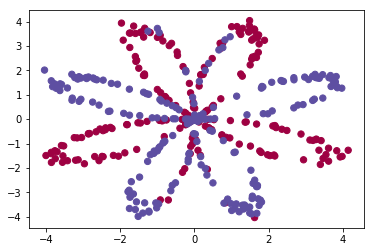

In [3]:
# plot the dataset - petals of the flower
plt.scatter(X_train[0, :], X_train[1, :], c = np.squeeze(Y_train), s=40, cmap=plt.cm.Spectral);

#### Define functions to build neural network

**Activation function (using Tensorflow) **
- Define activation function for sigmoid, tanh, relu and leaky-relu
- Sigmoid function $g(z) = \frac {1}{1+e^{-z}}$
- Tanh function $g(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$
- Relu function $g(z) = max(0, z)$
- Leaky relu function $g(z) = max(0.01z, z)$
- Softmax function (for multiclass output - usually more than two) $g(z) = \frac{e^{z}}{\sum^{L_n}e^{z}}$


In [4]:
# Activation function 
def activation(z, g):
    if g == 'sigmoid':
        result = tf.nn.sigmoid(z)
    elif g == 'relu':
        result = tf.nn.relu(z)
    elif g == 'lrelu':
        result = tf.nn.leaky_relu(z)
    elif g == 'tanh':
        result = tf.nn.tanh(z)
    elif g == 'softmax':
        result = tf.nn.softmax(z)
    else :
        result = z
    assert(z.shape[0] == result.shape[0])
    return(result)



**Parameter initialization**
- layers : list of number of units in each layer from 0 to L where L is total number of layers
- Forward values : Values used in forward propagation. Initialize W using Xavier's initialization to avoid exploding or vanishing gradient
    $ W^{[l]} = \frac{1}{\sqrt{n^{[l-1]}}} \times \mathcal{N}~(0,1)_{[n^{[l]},n^{[l-1]}]} $
- Backward grads : Values used in backward propagation

**Forward propagation** is propagating values from Input layer , through different layers with initiliazed parameters, to output layer. Below is what we calculate in each layer
- $Z^{[l]}=W^{[l]}.A^{[l-1]}+b^{[l]}$ 
- $A^{[l]}=g(Z^{[l]})$ 

where $Z$ and $A$ are matrixs with $m$ columns,
   - $.$ is dot product
   - $A$ is the activation value of each layer
   - $g()$ is the activation function.
   - $Z$ is input to activation units
   - $W$ is weights and b is the bias for each layer
   - $l$(layer) is the layer that ranges from 0 to L(total number of layers)
   - $m$ is the number of data points inputted into the system
   - $X$ is the input and also the 0th layer activation values, i.e $A^{[0]}$ 
   - $G$ is the list of activation function layerwise
    
- Propagation of values $A^{[0]}$ &rarr; $Z^{[1]}$ &rarr; $A^{[1]}$ &rarr; ... &rarr; $Z^{[l]}$ &rarr; $A^{[l]}$ &rarr; ... &rarr; $Z^{[L]}$ &rarr; $A^{[L]}$
- For drop out regularisation, switch off certain neural units of hidden layer based on keep_prob paramater. So $A^{[l]} = A^{[l]} * D^{[l]}$ where $D^{[l]}$ has same dimension as $A^{[l]}$ and value wise it has "keep_prob" percentage of Trues (1) and rest as False (0) during training while during prediction all units are to be active

**Gradient of loss**, **backward propagation** and **update parameters** are something Tensorflow handles internally.

**Neuralnet classifier** initializes the parameters for different layers defined with flexibility of
definining number of units per layers, number of layers itself, learning rate, keep probability for drop out regularization
and activation function for each layer.


To use the Neuralnet classifier we have designed, activate the following parameters 
- **hidden** : hidden layer units - an array of numbers of units in each layer. e.g. [8,5,4] is 3 layers with 8,5 and 4 units in the order. This is the only mandatory parameter to pass to initializer.
- **activations** : Type of activation function in each layer including output layer. Functions supported are sigmoid, tanh, relu and leaky-relu. Default setup is tanh for hidden layer and sigmoid for output layer.
- **alpha** : Learning rate for updating learnable parameters W (weights) and b (bias) in each iteration
- **keep_prob** : This defaulted to 0 however a value between 1 and 0 would indicate the percentage of units in a layer to be active during an learning iteration of epoch. This paramter is used for drop out regularization and 0 would mean no dropout used.  
- **lambda_R2** : Lambda parameter for $L_2$ regularization. 0 is deafult value and would mean no regularization.
- **batch_size** : batch_size would be a number (less than or equal to number of training examples) used for mini batch / stochastic gradient. Default would be full batch gradient descent.
- **optimizer** : Optimizer used to update trainable parameter to bring the cost down. Options are "Gradient-Descent" (default), "GD-with-Momentum" , "RMSprop-Optimizer" and "Adam-Optimizer".  
- **decay_rate** : Rate at which we can reduce alpha (learning rate) during each iteration. If the value is 0 (default) then there is no decay in the rate.


In [5]:
# Initialize classifier
def Neuralnet_clasifier(X, Y, alpha, params):
    
    # layers and units
    layers = [X_train.shape[0]]
    if 'hidden' in params.keys():
        hidden_layers = len(params['hidden'])
        if hidden_layers > 1:
            layers.extend(np.squeeze(params['hidden']))
        else :
            layers.append(np.squeeze(params['hidden']))
    layers.append(Y_train.shape[0])
    
    # Activation function
    Activation_function = [np.nan]
    if 'activations' in params.keys():
        Activation_function.extend(np.squeeze(params['activations']))
    else :
        Activation_function.extend(['tanh' for layer in range(hidden_layers)])
        Activation_function.append('sigmoid')
    assert(len(Activation_function) == len(layers))
    
    # Learning rate
    if 'alpha' in params.keys():
        assert(isinstance(params['alpha'],float))
        learning_rate = params['alpha']
    else :
        learning_rate = 1.2

        # Batch size
    if 'batch_size' in params.keys():
        assert(isinstance(params['batch_size'],int))
        batch_size = params['batch_size']
    else :
        batch_size = 0
        
    # decay_rate
    if 'decay_rate' in params.keys():
        assert(isinstance(params['decay_rate'],float))
        decay_rate = params['decay_rate']
    else :
        decay_rate = 0.0
        
    # optimizer
    if 'optimizer' in params.keys():
        optim_list = ["Gradient-Descent" , 
                      "GD-with-Momentum" ,
                      "RMSprop-Optimizer" ,
                      "Adam-Optimizer"  ]
        assert(params['optimizer'] in optim_list)
        optimizer = params['optimizer']
    else :
        optimizer = "Gradient-Descent"
        
    # Keep probability for drop out regularization
    if 'keep_prob' in params.keys():
        assert(isinstance(params['keep_prob'],float))
        keep_prob = params['keep_prob']
    else :
        keep_prob = 1.0

    # Lambda for L2 regularization
    if 'lambda_R2' in params.keys():
        assert(isinstance(params['lambda_R2'],float))
        lambd = params['lambda_R2']
    else :
        lambd = 0.0
    
    # Initialize model parameters
    parameters = {}
    parameters['layers'] = layers 
    parameters['alpha'] = learning_rate
    parameters['activations'] = Activation_function 
    parameters['batch_size'] = batch_size
    parameters['decay_rate'] = decay_rate
    parameters['optimizer'] = optimizer
    parameters['keep_prob'] = keep_prob
    parameters['lambda_R2'] = lambd
        
    tf.set_random_seed(1)     # for stability of results
         
    layers = parameters['layers']         
    G = parameters['activations']  
    
    W={}; b={}; Z={}; A={};        
    L = len(layers)-1  
               
    # Feed-forward network
    for layer in range(len(layers)):
        if layer == 0 :                                
            A[layer] = X
        else :
            # Intitialize W and b
            W[layer] = tf.get_variable(name='W'+str(layer), shape = [layers[layer],layers[layer-1]], dtype = tf.float32,
                                       initializer=tf.contrib.layers.xavier_initializer(seed=1))        
            b[layer] = tf.get_variable(name='b'+str(layer), shape = [layers[layer],1], dtype = tf.float32,
                                       initializer=tf.zeros_initializer)        
            assert(W[layer].shape==(layers[layer],layers[layer-1]))
            assert(b[layer].shape==(layers[layer],1))
        
            # For Z and A
            Z[layer] = tf.add(tf.matmul(W[layer],A[layer-1]),b[layer])            
            assert(Z[layer].shape[0] == layers[layer])            
            if (layer != len(layers)-1) & (keep_prob < 1.0):
                A[layer] = tf.nn.dropout(activation(Z[layer],G[layer]),keep_prob=keep_prob)
            else :
                A[layer] = activation(Z[layer],G[layer])
            assert(A[layer].shape[0] == layers[layer]) 
                        
    
    # Loss and Cost function
    Yhat = A[L]    
    if layers[-1] == 1 :
        loss = -tf.add(Y*tf.log(Yhat),(1-Y)*tf.log(1-Yhat)) 
    else :
        loss = -tf.reduce_sum(Y*tf.log(Yhat),axis=1)     
        
    if lambd != 0 :    
        for layer in range(len(layers))[1:] :
            loss = tf.add(loss, lambd*tf.nn.l2_loss(W[layer]))
            
    cost = tf.reduce_mean(loss)    
    
    # Optimizer 
    if optimizer == "Gradient-Descent" :
        optimizer_fn = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(cost)
    elif optimizer == "GD-with-Momentum" :
        optimizer_fn = tf.train.MomentumOptimizer(learning_rate=alpha).minimize(cost)
    elif optimizer == "RMSprop-Optimizer" :
        optimizer_fn = tf.train.RMSPropOptimizer(learning_rate=alpha).minimize(cost)
    elif optimizer == "Adam-Optimizer" :
        optimizer_fn = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
    
    # Values for forward propagation
    forward_propagation = [W, b, Z, A]  
    
    return(forward_propagation, cost, optimizer_fn, parameters)

**Neuralnet training** is called using the parameters from initializer to train the model using inputs and labels through mulitple iterations/epoch of forward propagation, backward propagation and update of W, b parameters with an objective of brining the cost of Loss down. Based on batch size, each epoch can be executed on multiple batches from your training examples and process is called as mini batch gradient. Stochastic gradient would be having mini batch size of 1. i.e. one training example per mini batch. 1 epoch is 1 pass through entire dataset and consist of 1 or more batches. 


In [6]:
# training and prediction function
def Neuralnet_training(X_train, Y_train, params, epochs = 10000, cost_print = 0, model_path = "./tmp/"): 
    
    # Reset the graph
    tf.reset_default_graph()
    
    # Input
    X = tf.placeholder(dtype=tf.float32,shape=[X_train.shape[0],None], name = 'X')
    Y = tf.placeholder(dtype=tf.float32,shape=[Y_train.shape[0],None], name = 'Y')
    alpha = tf.placeholder(dtype=tf.float32, name = 'alpha')
    
    #Initialize graph     
    forward_propagation, cost, optimizer_fn, parameters =  Neuralnet_clasifier(X, Y, alpha, params)
    
    # Batch division
    m = Y_train.shape[1]
    bch = parameters['batch_size']
    pool = []
    if bch != 0:        
        datapts = np.arange(m)
        np.random.shuffle(datapts)
        pool = datapts[:m-m%bch].reshape(-1,bch).tolist()
        if m%bch != 0:
            pool.append(datapts[m-m%bch:].tolist())
    else :
        pool.append(np.arange(m))
    
    learning_rate = parameters['alpha']  
    rate = learning_rate
    decay_rate = parameters['decay_rate']
    layers = parameters['layers']  
    L = len(layers)-1  
    
    W, b, Z, A = forward_propagation
    
    init = tf.global_variables_initializer()
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    # Execute tensorflow in session
    with tf.Session() as sess :
        sess.run(init)
        Epoch = []; Cost = []
        for epoch in range(epochs) :
            
            # Learning rate decay
            rate = (learning_rate/(1+decay_rate*epoch))
            bch_cost = 0
            
            for poolid in pool :                
                cost_val,_ = sess.run([cost, optimizer_fn], 
                                      feed_dict = {X:X_train[:,poolid],Y:Y_train[:,poolid],
                                                  alpha:rate})
                bch_cost += cost_val/len(pool) 
                
            if (cost_print !=0):
                if ((epoch % cost_print == 0) or (epoch == epochs - 1)):
                    print("After {} epoch , cost is {}".format(epoch+1,bch_cost)) 
                if (epoch%(epochs/100) == 0):
                    Epoch.append(epoch)
                    Cost.append(bch_cost)
            
        ## Save the variables to disk.
        save_path = saver.save(sess, model_path)
        print("Model saved at path: %s" % save_path)
    
    if (cost_print !=0):
        plt.plot(Epoch,Cost)
        plt.title("Cost of incorrect prediction against epoch")
        plt.xlabel("Epoch - one pass through entire data")
        plt.ylabel("Cost of incorrect prediction")
        plt.show()
    
    
    return(forward_propagation, bch_cost, parameters, saver)



#### Initialize the model


In [7]:
# Initialize model 
params = {}
params['hidden'] = [5,5,4] # Hidden layers with units
params['activations'] = ['tanh','tanh','tanh','sigmoid'] # Activation functions for hidden layer and output layer
params['alpha'] = 0.008 # Learning rate 
params['batch_size'] = 100  # Batch size for mini batch / stochastic gradient
params['decay_rate'] = 1e-4  # Learning rate decay
params['keep_prob'] = 1.0  # Keep probability for drop out regularization
params['lambda_R2'] = 0.001  # Lambda for L2 regularization
params['optimizer'] = 'Adam-Optimizer'  # Optimizer



#### Train the Neuralnet model using the data (X and Y)

After 1 epoch , cost is 0.7314208149909973
After 301 epoch , cost is 0.26620251685380936
After 601 epoch , cost is 0.25477728992700577
After 901 epoch , cost is 0.24865087866783142
After 1201 epoch , cost is 0.2444053553044796
After 1501 epoch , cost is 0.24174608662724495
After 1801 epoch , cost is 0.24035978689789772
After 2101 epoch , cost is 0.23964882642030716
After 2401 epoch , cost is 0.23927892372012138
After 2701 epoch , cost is 0.23903503268957138
After 3000 epoch , cost is 0.23884529620409012
Model saved at path: ./tmp/


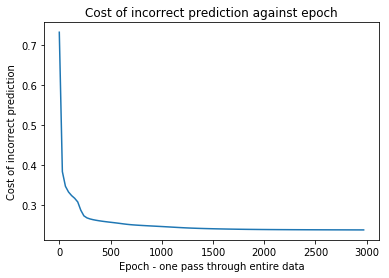

In [8]:
# Training the initialized neuralnet with data X and Y
forward_propagation, bch_cost, parameters, saver = Neuralnet_training(X_train, Y_train, params, epochs = 3000, cost_print = 300)

#### Predict the output using trained Neuralnet

In [9]:
# For Prediction based on trained parameters
def Neuralnet_predict(X_pred, parameters, forward_propagation, saver, model_path = "./tmp/"):
    
    layers = parameters['layers']  
    L = len(layers)-1  
    W, b, Z, A = forward_propagation
    
    # Input
    X = tf.placeholder(dtype=tf.float32,shape=[X_pred.shape[0],None], name = 'X')
    
    with tf.Session() as sess :
        saver.restore(sess, model_path)
        print(X_pred.shape)
        Y_pred = sess.run(A[L], feed_dict ={'X:0':X_pred})
    
    return(Y_pred > 0.5)

In [10]:
# Prediction on training data
pred = Neuralnet_predict(X_train, parameters, forward_propagation, saver)
print("Accuracy on training data is {} %".format(np.sum(pred == Y_train)*100/Y_train.shape[1]))

INFO:tensorflow:Restoring parameters from ./tmp/
(2, 400)
Accuracy on training data is 90.75 %


#### Plot the decision boundary of the trained neuralnet classifier

In [11]:
# Function to plot decision boundary
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


INFO:tensorflow:Restoring parameters from ./tmp/
(2, 1026144)


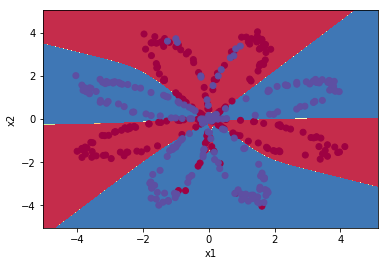

In [12]:
# Plot the decision boundary
plot_decision_boundary(lambda x: Neuralnet_predict(x.T, parameters, forward_propagation, saver), X_train, np.squeeze(Y_train))